# Samples analysis
Analysis of posterior samples

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.60' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from numpy.testing import assert_allclose
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

2024-06-24 16:26:46.408287: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Import

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_loc, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int), box_size=256*np.ones(3))
config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int), fourier=True)
# config.update(a_lpt=0.1, mesh_size=64*np.ones(3, dtype=int), fourier=False)
model = partial(pmrsd_model, **config)
print_config(model)
expe_prefix = "fourier_"

# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_loc(model)))
fiduc_params = get_simulator(fiduc_model)(rng_seed=0)
fiduc_params_ = param_fn(inverse=True, **param_fn(**fiduc_params))

# Chain init
@jit
@vmap
def sample_init_chains(rng_key, scale_std):
    params_ = seed(prior_model, rng_key)(**config)
    params = get_param_fn(scale_std=scale_std, **config)(**params_)
    return get_param_fn(**config)(inverse=True, **params)

init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array(7*[1/10]))
init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), fiduc_params_, init_params_)
pickle_dump(fiduc_params, save_dir + expe_prefix + "fiduc_params.p")
pickle_dump(init_params_, save_dir + expe_prefix + "init_params_.p")

# Load fiducial and chain init params
# fiduc_params = pickle_load(save_dir + expe_prefix + "fiduc_params.p")
# init_params_ = pickle_load(save_dir + expe_prefix + "init_params_.p")

# Condition model on observables
obs_names = ['obs_mesh']
# obs_names = ['obs_mesh','b1_','b2_','bs2_','bn2_']
# obs_names = ['obs_mesh','Omega_m_','sigma8_','b1_','b2_','bs2_','bn2_']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0], 'init_mesh': ['{\\delta}_L', None, None]}, 'fourier': True, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [3]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['b1_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.13291842 -0.33102584  1.2052755  -1.239476    1.30549    -2.1787713
  0.3523351   0.13016473] 
 [ 0.         -0.78078747  0.5815921   0.00989425  0.0184391  -2.0398915
 -0.7531326  -0.07692424] 
 [ 0.91338354  0.75811934  0.8671335   0.97199315  2.3013043  -1.3022848
 -0.6570514   1.6659713 ]


In [4]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['b1_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.         -0.          0.05815921  0.00098942  0.00184391 -0.20398915
 -0.07531326 -0.00769242] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


## Single run analysis

In [3]:
aa = dict(b=2, cc=3)
all([k in aa for k in ['b','cc','c']])

False

In [26]:
slc = [slice(None)] * aa.ndim
slc[2] = slice(0, None, 3)
# jnp.take_along_axis(aa, indices=slice(0,2,2), axis=2)
aa[tuple(slc)]

AttributeError: 'dict' object has no attribute 'ndim'

In [124]:
for i in jnp.arange(0,10,3):print(i)

0
3
6
9


In [188]:
aa = {"a":jnp.ones((2,33,5,4))}
axis = 1
thinning = 7


aggr_fn = lambda y: jnp.moveaxis(jnp.mean(y[...,None]**jnp.array([1,2,3]), axis%y.ndim), -1, axis%y.ndim)
latent = tree_map(lambda x:
                      jnp.stack(tree_map(aggr_fn, 
                                         jnp.array_split(x, jnp.ceil(x.shape[axis]/thinning), axis%x.ndim)), 
                        axis%x.ndim), aa) # thin splits by taking last or moments
latent["a"].shape

(2, 5, 3, 5, 4)

In [176]:
aa = jnp.arange(5)
aa = jnp.tile(aa, (8,*len(jnp.shape(aa))*[1]))
ids = jr.choice(jr.key(0), aa.shape[-1], shape=(5,), replace=False), 
jr.choice(jr.key(0), aa, shape=(5,), replace=False, axis=1), ids

(Array([[1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2],
        [1, 0, 4, 3, 2]], dtype=int32),
 (Array([1, 0, 4, 3, 2], dtype=int32),))

In [194]:
aa = dict(a=jnp.ones((2,3,4)), b=jnp.ones((2,3,5,6)))
jnp.take_along_axis(list(aa.values())[0], (0,1)).shape

TypeError: take_along_axis() missing 1 required positional argument: 'axis'

In [4]:
def separate(dic, blocks, rest=True):
    parts = []
    dic = dic.copy()
    for b in blocks:
        parts.append({k:dic.pop(k) for k in b})
    if rest:
        parts.append(dic)
    return parts


# def separate(samples, separ=['n_evals']):
#     samples = samples.copy()
#     samples2 = {name:samples.pop(name) for name in separ}
#     return samples, samples2

def recombine(dic, blocks, block_names, rest=True, aggr_fn=jnp.stack):
    combined = {}
    dic = dic.copy()
    for b, bn in zip(blocks, block_names):
        combined[bn] = aggr_fn(jnp.stack([dic.pop(k) for k in b]))
    if rest:
        combined |= dic
    return combined

def get_separate_latent(prior_config, **config):
    block = np.array(list(prior_config.keys()))[None]
    def separate_latent(samples, rest=True):

        # Handle standardized latend params
        if all([k + '_' in samples for k in block]):
            for i, b in enumerate(block):
                block[i] = b + '_'

        # Handle infos
        block.append(["n_evals"])
        return separate(samples, block, rest)
    return separate_latent

separate_latent = get_separate_latent(**config)



def thin_chains(samples, thinning=1, moments=None, axis=1):
    latent, info, rest = separate_latent(samples, rest=True)
    if moments is None:
        aggr_fn = lambda y: jnp.take(y,-1,axis)
    else:
        moments = jnp.atleast_1d(moments)
        aggr_fn = lambda y: jnp.moveaxis(jnp.mean(y[...,None]**moments, axis%y.ndim), -1, axis%y.ndim)
        ones_latent = {"n_aggr": jnp.ones_like(list(latent.values())[0][:axis+1])}
        ones_aggr_fn = lambda y: jnp.moveaxis(jnp.sum(y[...,None]**moments, axis%y.ndim), -1, axis%y.ndim)

    latent = tree_map(lambda x:
                      jnp.stack(tree_map(aggr_fn, 
                                         jnp.array_split(x, jnp.ceil(x.shape[axis]/thinning), axis%x.ndim)), 
                        axis%x.ndim), latent) # thin splits by taking last or moments
    
    if moments is not None:
        ones_latent = tree_map(lambda x:
                      jnp.stack(tree_map(ones_aggr_fn, 
                                         jnp.array_split(x, jnp.ceil(x.shape[axis]/thinning), axis%x.ndim)), 
                        axis%x.ndim), ones_latent) # thin splits by taking last or moments

    info = tree_map(lambda x:
                    jnp.stack(tree_map(lambda y:
                                       jnp.sum(y, axis), 
                                       jnp.array_split(x, jnp.ceil(x.shape[axis]/thinning), axis%x.ndim)), 
                        axis%x.ndim), info) # sum n_evals
    return latent | info | rest



def choice_cell_chains(rng_key, samples, n):
    latent, info, rest = separate_latent(samples, rest=True)
    names = ['init_mesh']

    # Handle standardized latend params
    if all([k + '_' in samples for k in names]):
        for i, b in enumerate(names):
                names[i] = b + '_'

    for name in names:
        value = latent[name]
        latent[name] = jr.choice(rng_key, value.reshape((*value.shape[:2],-1)), 
                         shape=(n,), replace=False, axis=-1)

    return latent | info | rest


def param_chains(samples):
    latent, info, rest = separate_latent(samples, rest=True)
    latent = vmap(vmap(param_fn))(**latent)
    return latent | info | rest

# def combine(moments, axis=0):
#     moments, infos = separate(moments)
#     moments = tree_map(lambda x: x.mean(axis=axis), moments)
#     infos = tree_map(lambda x: x.sum(axis=axis), infos)
#     return moments | infos

# def get_moments(x_, axis=0):
#     x_, infos = separate(x_)
#     moments = tree_map(lambda x: jnp.stack([x, x**2], axis=2), vmap(vmap(param_fn))(**x_))
#     return combine(moments | infos, axis=axis)

def choice_cells(x_, rng_key, n):
    x_, infos = separate(x_)
    x = vmap(vmap(param_fn))(**x_)
    name = 'init_mesh'
    init_mesh = x[name]
    x[name] = jr.choice(rng_key, init_mesh.reshape((*init_mesh.shape[:2],-1)), 
                         shape=(n,), replace=False, axis=2)
    return x | infos

## For Chains, ESS, GR
conc_axis = [1] # axis: run x chain x sample 
var_names = [name+'_' for name in config['prior_config']] + ['n_evals']
# var_names = ['Omega_m_', "sigma8_"] + ['num_steps']
transform = lambda x:x
# var_names = None
# transform = lambda x: vmap(vmap(param_fn))(**tree_map(lambda x_:x_[:,::16], x))
load_chains_ = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

var_names = [name+'_' for name in config['prior_config']] + ['n_evals'] + ['init_mesh_']
# var_names = ['Omega_m_', "sigma8_"] + ['num_steps'] + ['init_mesh_']
transform = jit(partial(choice_cells, rng_key=jr.key(1), n=50))
load_chains = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

## For Errors
conc_axis = []
var_names = [name+'_' for name in config['prior_config']] + ['n_evals'] + ['init_mesh_']
transform = jit(partial(get_moments, axis=(1)))
load_moments = partial(load_runs, var_names=var_names, conc_axis=conc_axis, transform=transform, verbose=True)

In [29]:
metric_traj = recombine(samples, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(jnp.mean, axis=0))

In [30]:
samples['b1'].shape

(8, 320)

In [31]:
metric_traj['cosmo'].shape

(8, 320)

In [5]:
# load_path = save_dir + f"MCLMC/MCLMC_ns8192_x_nc8"
# load_path = save_dir + f"NUTSGibbs/HMCGibbs_ns256_x_nc8"
# load_path = save_dir + f"NUTSGibbs2/NUTSGibbs_ns256_x_nc8"
# load_path = save_dir + f"NUTS/NUTS_ns256_x_nc8"
load_path = save_dir + f"NUTS_nc8_x_ns128_fourier2"
# load_path = save_dir + f"HMC/HMC_ns256_x_nc8"
# load_path = save_dir + f"NUTS_nc8_x_ns64_test"
# load_path = save_dir + f"NUTS_nc8_x_ns64_test2"
start_run, end_run = 0,5

samples_ = load_chains_(load_path, start_run, end_run)
samples = load_chains(load_path, start_run, end_run)
# samples = jit(vmap(param_fn))(**samples_) | separate(samples_)[1]
# moments = load_moments(load_path, start_run, end_run)
# TODO: load within a dict insteaf of list, with mc_label. Then can tree_map that
# pickle_dump(combine(moments, axis=(0,1)), save_dir+"NUTS/NUTS_moments20.p")

# n_comb = 4
# for i in range(1,2):
#     start_run, end_run = 1+(i-1)*n_comb,i*n_comb
#     transform = lambda x: tree_map(lambda y : y[:,::n_comb], x)
#     var_names = None
#     samples_ = load_runs(load_path, start_run, end_run, var_names, conc_axis=[1], transform=transform, verbose=True)
#     pickle_dump(samples_, save_dir + f"HMC/HMC_ns1024_x_nc8_{i}.p")

loading: NUTS_nc8_x_ns128_fourier2, from run 0 to run 5 (included)
total n_samples: (8, 768), total n_evals: [452608 285568 450180 284684 451328 284690 286080 450304]

loading: NUTS_nc8_x_ns128_fourier2, from run 0 to run 5 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 768), total n_evals: [452608 285568 450180 284684 451328 284690 286080 450304]



### Chain

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            Omega_m      0.30      0.01      0.30      0.28      0.31    529.45      1.01
                 b1      1.00      0.03      1.00      0.95      1.05    207.78      1.04
                 b2      0.00      0.01      0.00     -0.02      0.03    310.77      1.02
                bn2     -0.34      0.34     -0.34     -0.91      0.22    585.35      1.01
                bs2      0.03      0.05      0.03     -0.06      0.11    312.29      1.02
   init_mesh[0,0,0]     -0.26      0.85     -0.26     -1.63      1.14   4603.91      1.00
   init_mesh[0,0,1]     -0.27      0.79     -0.26     -1.59      1.00   4919.96      1.00
   init_mesh[0,0,2]      0.65      0.83      0.65     -0.68      2.07   5211.90      1.00
   init_mesh[0,0,3]      0.11      0.80      0.11     -1.23      1.38   3945.64      1.00
   init_mesh[0,0,4]     -0.14      0.84     -0.15     -1.52      1.25   3737.45      1.00
   init_m

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



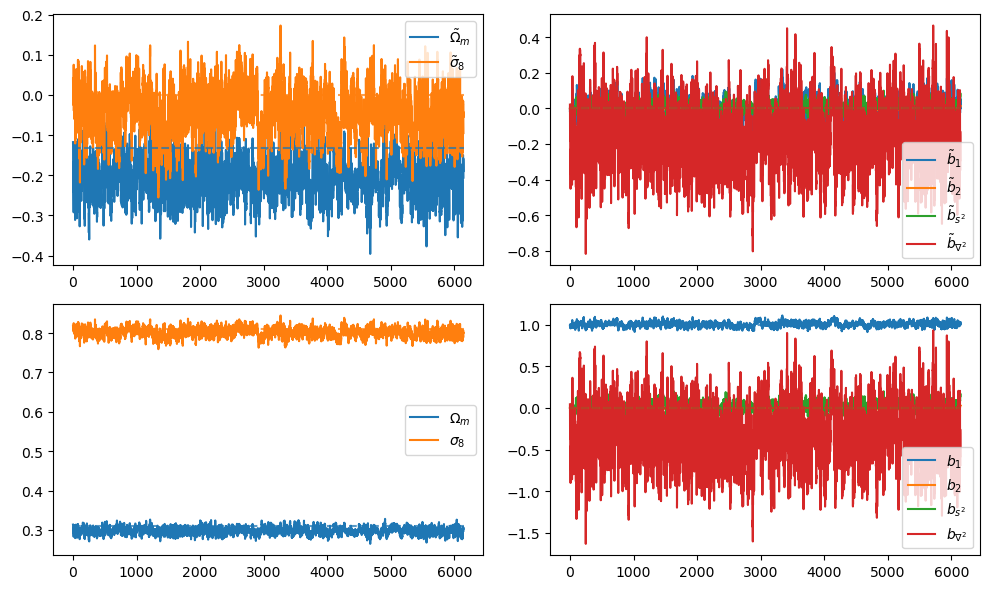

In [6]:
%matplotlib inline
def _plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a standardized latent value 
            lab = "\\tilde"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)

def plot_chain(samples_:dict, prior_config:dict, fiduc:dict, verbose=True, **config):
    # Print diagnostics
    samples = jit(vmap(vmap(param_fn)))(**samples_)
    if verbose:
        from numpyro.diagnostics import print_summary
        print_summary(samples, group_by_chain=True) # NOTE: group_by_chain if several chains

    # Concatenate and reparam chains
    samples_ = tree_map(lambda x: jnp.concatenate(x, axis=0), samples_)
    samples = tree_map(lambda x: jnp.concatenate(x, axis=0), samples)

    # Plot chains
    plot_fn = partial(_plot_chain, prior_config=prior_config, fiduc=fiduc)
    plt.figure(figsize=(10,6))
    plt.subplot(221)
    plot_fn({name:samples_[name] for name in ['Omega_m_','sigma8_']})
    plt.legend(), 
    plt.subplot(222)
    plot_fn({name:samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
    plt.legend(), 
    plt.subplot(223)
    plot_fn({name:samples[name] for name in ['Omega_m','sigma8']})
    plt.legend(), 
    plt.subplot(224)
    plot_fn({name:samples[name] for name in ['b1', 'b2','bs2','bn2']})
    plt.legend(), 
    plt.tight_layout()

# sli_toplot = slice(0,300)
sli_toplot = slice(0,None)
# plot_chain(post_samples_[1], fiduc=fiduc_params, **config)
# plot_chain(samples_, fiduc=fiduc_params, **config)
plot_chain(tree_map(lambda x:x[:,sli_toplot], samples_), fiduc=fiduc_params, **config)
# mlflow.log_figure(plt.gcf(), f"MCLMC_chain_L25_ss2_invmm.svg")
plt.show();

Removed no burn in
# test
using 6144 rows, 6 parameters; mean weight 1.0, tot weight 6144.0
Equiv number of single samples (sum w)/max(w): 6144
Effective number of weighted samples (sum w)^2/sum(w^2): 6144


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.28      0.31    534.99      1.00
        b1      1.00      0.03      1.00      0.95      1.05    212.70      1.01
        b2      0.00      0.01      0.00     -0.02      0.03    319.93      1.00
       bn2     -0.34      0.34     -0.34     -0.91      0.22    571.43      1.00
       bs2      0.03      0.05      0.03     -0.06      0.11    325.05      1.01
    sigma8      0.80      0.01      0.80      0.78      0.82    269.81      1.01



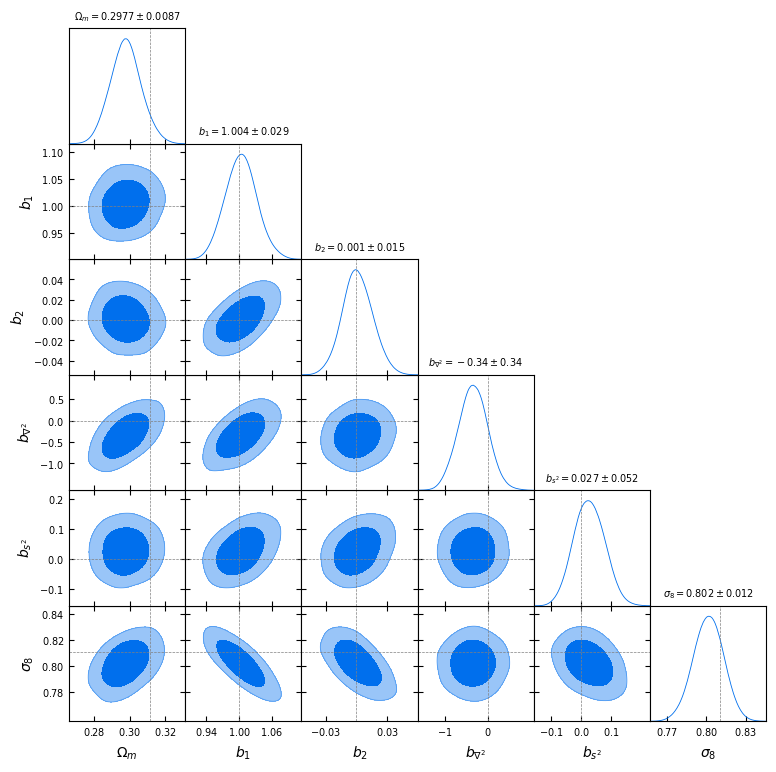

In [7]:
%matplotlib inline
from montecosmo.utils import get_gdsamples, get_gdprior

conc_samples = [tree_map(lambda x: jnp.concatenate(x, axis=0), separate(s, ['n_evals','init_mesh'])[0]) for s in [samples]]
gdsamples = get_gdsamples(conc_samples, label=["test"], verbose=True, **config)
# for i_gds, gds in enumerate(gdsamples): 
#     gdsamples[i_gds] = gds.copy(label=["test"][i_gds]+", 1$\\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})
# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))

g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r'
g.triangle_plot(roots=gdsamples, 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

In [27]:
from numpyro.diagnostics import effective_sample_size, gelman_rubin

def get_metric_traj(metric_fn, samples, n, axis=0, true=None):
    """
    """ # TODO: make such that no need to pass true, maybe by partial metrif_fn?
    samples, infos = separate(samples)
    if true is not None:
        true, true_infos = separate(true)

    def get_fn_traj(fn, samples, *args):
        metrics = []
        length = samples.shape[axis]
        for i_filt in np.arange(length, 1, -length// n)[::-1]:
            filt = jnp.arange(i_filt)
            metrics.append(fn(samples.take(filt, axis=axis), *args))
        return jnp.stack(metrics)
    
    get_infos_traj = partial(get_fn_traj, lambda x: x.sum())
    infos_traj = tree_map(get_infos_traj, infos)
    get_metric_traj = partial(get_fn_traj, metric_fn)
    if true is not None:
        metric_traj = tree_map(get_metric_traj, samples, true)
    else:
        metric_traj = tree_map(get_metric_traj, samples)
    return metric_traj | infos_traj


def geomean(x, axis=None):
    return jnp.exp( jnp.log(x).mean(axis=axis) )
multi_ess_fn = lambda x: geomean(effective_sample_size(x))
def grmean(x, axis=None):
    """cf. https://arxiv.org/pdf/1812.09384"""
    return (1 + geomean(x**2 - 1, axis=axis) )**.5
multi_gr_fn = lambda x: grmean(gelman_rubin(x))
def multi_gr_fn2(x):
    n_chains = x.shape[0]
    return geomean(gelman_rubin(x)**2 - 1) / n_chains # about 1/N_eff

sqrerr_moments_fn = lambda m, m_true: (m.mean(axis=(0,1))-m_true)**2
@jit
def sqrerr_locscale_fn(moments, moments_true):
    # Get mean and std from runs and chains
    m1_hat, m2_hat = moments.mean(axis=(0,1))
    m1, m2 = moments_true
    std_hat, std = (m2_hat - m1_hat**2)**.5, (m2 - m1**2)**.5 # Huygens formula
    # Compute normalized errors
    err_loc, err_scale = (m1_hat - m1) / std, (std_hat - std) / (std / 2**.5) # asymptotically N(0, 1/n_eff)
    mse_loc, mse_scale = (err_loc**2).mean(), (err_scale**2).mean() # asymptotically 1/n_eff * chi^2(d)/d
    return jnp.stack([mse_loc, mse_scale])

@jit
def sqrerr_locscale_fn2(moments, moments_true):
    # Get mean and std from runs
    n_chains = moments.shape[1]
    m_hat = moments.mean(axis=(0))
    m1_hat, m2_hat = m_hat[:,0], m_hat[:,1]
    m1, m2 = moments_true
    std_hat, std = (m2_hat - m1_hat**2)**.5, (m2 - m1**2)**.5 # Huygens formula
    # Compute normalized errors
    err_loc, err_scale = (m1_hat - m1) / std, (std_hat - std) / (std / 2**.5) # asymptotically N(0, n_chain/n_eff)
    mse_loc, mse_scale = (err_loc**2).mean(), (err_scale**2).mean() # asymptotically n_chain/n_eff * chi^2(d*n_chain)/(d*n_chain) 
    return jnp.stack([mse_loc, mse_scale]) / n_chains # asymptotically 1/n_eff * chi^2(d*n_chain)/(d*n_chain) 

In [11]:
n_toplot = 100
# ESSs = get_metric_traj(effective_sample_size, samples, n_toplot, 1)
# GRs = get_metric_traj(gelman_rubin, samples, n_toplot, 1)
ESSs = get_metric_traj(multi_ess_fn, samples, n_toplot, 1)
# GRs = get_metric_traj(multi_gr_fn, samples, n_toplot, 1)
GRs = get_metric_traj(multi_gr_fn2, samples, n_toplot, 1)

moments_true = pickle_load(save_dir+"NUTS/NUTS_moments20.p")
# SEs = get_metric_traj(sqrerr_moments_fn, moments, n_toplot, 0, moments_true)
# NMSEs = get_metric_traj(sqrerr_locscale_fn, moments, n_toplot, 0, moments_true)
NMSEs = get_metric_traj(sqrerr_locscale_fn2, moments, n_toplot, 0, moments_true)

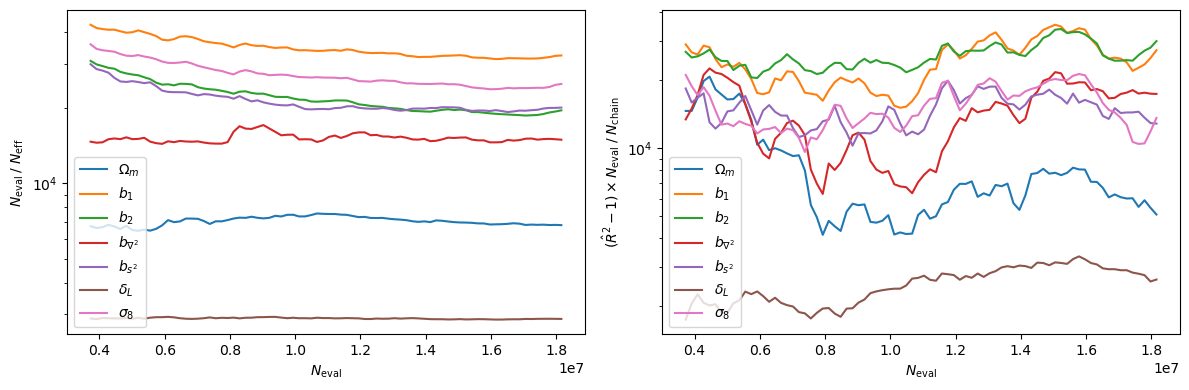

In [ ]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj, infos_traj = separate(ESSs)
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    if name == 'init_mesh':
        label = "$\\delta_L$"
    else:
        label = '$'+config['prior_config'][name][0]+'$'
    plot_fn(val, label=label)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

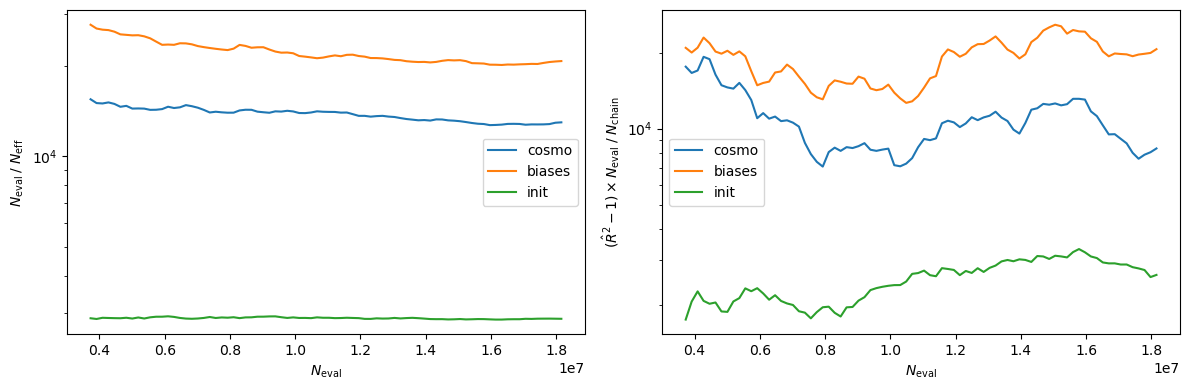

In [ ]:
plt.figure(figsize=(12,4))
sli_plot = slice(20,None)

plt.subplot(121)
metric_traj, infos_traj = separate(ESSs)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(geomean, axis=0))
num_steps = infos_traj['num_steps']
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.legend()

plt.subplot(122)
metric_traj, infos_traj = separate(GRs)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        # aggr_fn=partial(grmean, axis=0))
                        aggr_fn=partial(geomean, axis=0))
num_steps = infos_traj['num_steps']
# plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
for name, val in metric_traj.items():
    plot_fn(val, label=name)
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.legend()
plt.tight_layout()
plt.show();

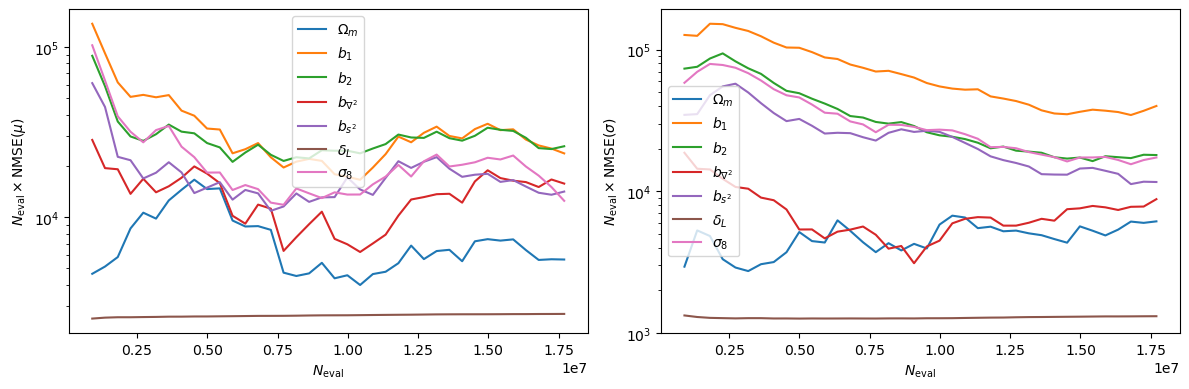

In [40]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :
    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        if name == 'init_mesh':
            label = "$\\delta_L$"
        else:
            label = '$'+config['prior_config'][name][0]+'$'
        plot_fn(val, label=label)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

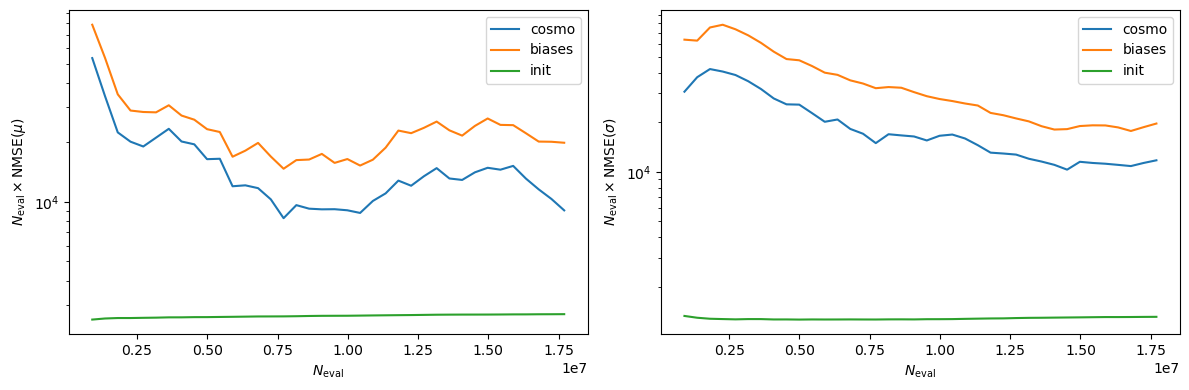

In [44]:
plt.figure(figsize=(12,4))
sli_plot = slice(0,-1)
metric_traj = recombine(metric_traj, 
                        [['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
                        ['cosmo','biases','init'], 
                        aggr_fn=partial(jnp.mean, axis=0))
metric_traj, infos_traj = separate(NMSEs)
num_steps = infos_traj['num_steps']

for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    plt.subplot(1, 2, i_plot+1)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
    for name, val in metric_traj.items():
        plot_fn(val, label=name)
    plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.legend()
plt.tight_layout()
plt.show();

## Multiple runs analysis

In [44]:
paths = ["HMC/HMC_ns256_x_nc8","NUTS/NUTS_ns256_x_nc8","NUTSGibbs2/NUTSGibbs_ns256_x_nc8"]
load_paths = np.array([os.path.join(save_dir, path) for path in paths])
mc_labels = ["HMC","NUTS","NUTSGibbs"]
# start_run, end_run = [2,1,2,1], [64,20,32,20]
start_run, end_run = [2,1,7], [64,20,20]
# start_run, end_run = [1,1,1], [5,5,5]

# moments = load_moments(load_paths, start_run, end_run)

# samples_ = load_chains_(load_paths, start_run, end_run)
samples = load_chains(load_paths, start_run, end_run)
# samples = [jit(vmap(param_fn))(**s_) | separate(s_)[1] for s_ in samples_]

loading: HMC_ns256_x_nc8, from run 2 to run 64 (included)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


total n_samples: (8, 16128), total n_evals: [3306240 3935232 4032000 4015872 3935232 3741696 2919168 2709504]

loading: NUTS_ns256_x_nc8, from run 1 to run 20 (included)
total n_samples: (8, 5120), total n_evals: [5237760 5237760 5237760 5237760 5237760 5237760 5237760 5237760]

loading: NUTSGibbs_ns256_x_nc8, from run 7 to run 20 (included)
total n_samples: (8, 3584), total n_evals: [3719620 3714302 3707724 3718660 3707108 3713154 3710462 3706174]



In [ ]:
from numpyro.diagnostics import print_summary
for lab, s in zip(mc_labels, samples):
    print(f"# {lab}")
    print_summary(separate(s)[0], group_by_chain=True) # NOTE: group_by_chain if several chains

# HMC

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      Omega_m      0.30      0.01      0.30      0.29      0.32   4126.13      1.00
           b1      0.97      0.03      0.97      0.92      1.02    810.88      1.01
           b2     -0.03      0.01     -0.03     -0.05     -0.01   1512.12      1.01
          bn2     -0.62      0.35     -0.63     -1.18     -0.04   1739.52      1.00
          bs2      0.01      0.05      0.01     -0.07      0.10   1297.34      1.01
 init_mesh[0]     -0.59      0.80     -0.60     -1.95      0.70  10594.20      1.00
 init_mesh[1]     -0.54      0.85     -0.54     -1.92      0.86  13746.39      1.00
 init_mesh[2]     -0.22      0.84     -0.21     -1.59      1.16  12920.03      1.00
 init_mesh[3]      0.76      0.77      0.75     -0.47      2.07   9727.48      1.00
 init_mesh[4]      0.62      0.81      0.62     -0.71      1.95   7170.34      1.00
 init_mesh[5]      0.17      0.78      0.16     -1.10      1.45   980

In [ ]:
n_toplot = 200
ESSs = [get_metric_traj(multi_ess_fn, s, n_toplot, 1) for s in samples]
GRs = [get_metric_traj(multi_gr_fn2, s, n_toplot, 1) for s in samples]
moments_true = pickle_load(save_dir+"NUTS/NUTS_moments20.p")
# NMSEs = [get_metric_traj(sqrerr_locscale_fn, m, n_toplot, 0, moments_true) for m in moments]
NMSEs = [get_metric_traj(sqrerr_locscale_fn2, m, n_toplot, 0, moments_true) for m in moments]

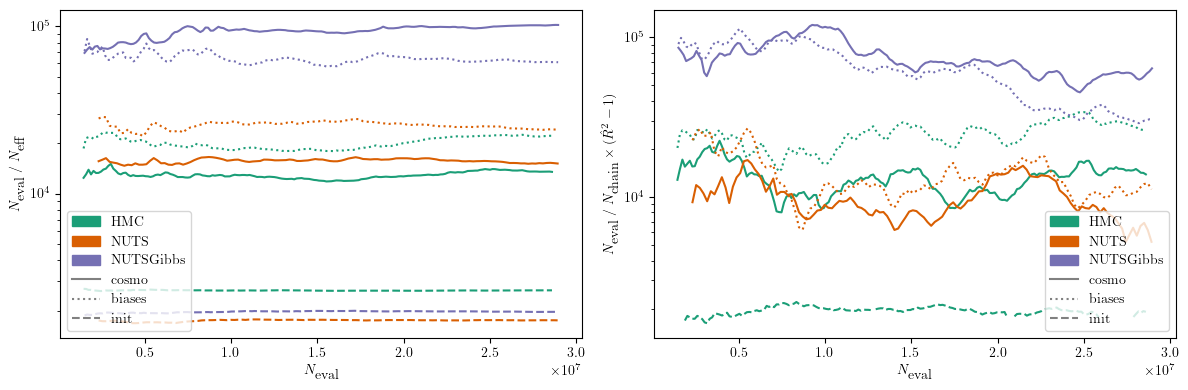

In [35]:
sli_plot = slice(10,None)
sli_plots = len(samples) * [sli_plot]
sli_plots = [slice(10,None), slice(10,2*68), slice(10,195)]
# sli_plots = [slice(2*15,None), slice(2*10,2*68), slice(2*8,2*53)]
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']
recomb_cbi = partial(recombine, 
					 block=[['Omega_m','sigma8'],['b1','b2','bs2','bn2'],['init_mesh']], 
					 block_name=['cosmo','biases','init']) 

plt.figure(figsize=(12,4))
plt.subplot(121)
trajs = []
for m in ESSs: # TODO: modify to not do for loop but instead tree_map and first dim is sampler dim
    traj = recomb_cbi(m, aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)

theme_switch(usetex=True)
# plt.subplot(1, 2, 1)
for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps / x.T).T[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles, loc="lower left")




plt.subplot(1, 2, 2)
trajs = []
for m in GRs:
    traj = recomb_cbi(m, 
                    # aggr_fn=partial(grmean, axis=0))
                      aggr_fn=partial(geomean, axis=0))
    trajs.append(traj)

for i_traj, traj in enumerate(trajs):
    metrics, infos = separate(traj)
    num_steps = infos['num_steps']
    sli_plot = sli_plots[i_traj]

    # plot_fn = lambda x, **kwargs: plt.plot(num_steps[sli_plot], x[sli_plot], **kwargs)
    plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x)[sli_plot], **kwargs)
    for i_val, (name, val) in enumerate(metrics.items()):
        plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val])

# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$\\hat R$")
# plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}}\\;/\\;N_{\\text{chain}} \\times (\\hat R^2 - 1)$")
plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{chain}} \\times (\\hat R^2 - 1)$")
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(trajs)):
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
for i_val, name in enumerate(metrics):
    handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
plt.legend(handles=handles)
plt.tight_layout()
# plt.savefig('ess_traj.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

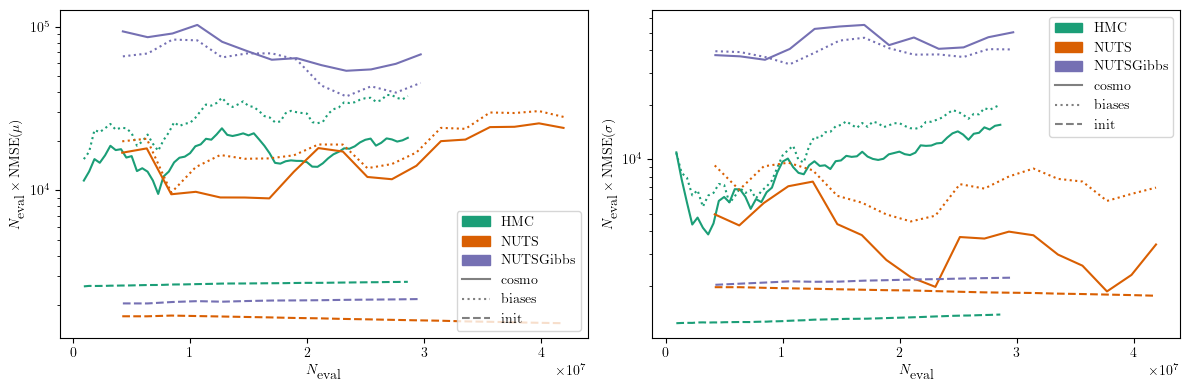

In [36]:
sli_plot = slice(0,None)
colors = [plt.get_cmap('Dark2')(i/7) for i in range(7)]
# colors = ['C'+str(i) for i in range(7)]
linestyles = ['-',':','--']

trajs = []
for m in NMSEs:
    traj = recomb_cbi(m, aggr_fn=partial(jnp.mean, axis=0))
    trajs.append(traj)

plt.figure(figsize=(12,4))
for i_plot, name_stat in enumerate(['\\mu','\\sigma']) :

    # markers = ['+','^']
    plt.subplot(1, 2, i_plot+1)
    markers = 2*[None]

    for i_traj, traj in enumerate(trajs):
        metrics, infos = separate(traj)
        num_steps = infos['num_steps']
        # if i_traj ==2: print(num_steps)

        plot_fn = lambda x, **kwargs: plt.semilogy(num_steps[sli_plot], (num_steps * x.T[i_plot])[sli_plot], **kwargs)
        for i_val, (name, val) in enumerate(metrics.items()):
            plot_fn(val, label=name, color=colors[i_traj], linestyle=linestyles[i_val], marker=markers[i_plot])

    # plt.xlabel("$N_{\\text{eval}}$"), plt.ylabel("$N_{\\text{eval}} \\times \\operatorname{NMSE}("+name_stat+")$")
    plt.xlabel("$N_{\\textrm{eval}}$"), plt.ylabel("$N_{\\textrm{eval}} \\times \\textrm{NMSE}("+name_stat+")$")
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    # handles, labels = plt.gca().get_legend_handles_labels()
    handles = []
    for i_traj in range(len(trajs)):
        handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
    for i_val, name in enumerate(metrics):
        handles.append(Line2D([], [], color='grey', linestyle=linestyles[i_val], label=name))
    plt.legend(handles=handles)
plt.tight_layout()
plt.show();

In [37]:
def get_first_after(dic, thres, verbose=False, mult=True):
	metrics, infos = separate(dic)
	num_steps = infos['num_steps']
	i_thres = (num_steps > thres).argmax(axis=0)
	ns = num_steps[i_thres]
	if verbose:
		print(f"relerr: {(ns - thres)/thres:.0e}")
	if mult:
		return tree_map(lambda x: ns * x[i_thres], metrics)
	else:
		return tree_map(lambda x: ns / x[i_thres], metrics)


# thres = 2.8*1e7
thres = 2.5*1e7
ESS1 = [recomb_cbi(get_first_after(m, thres, True, False), aggr_fn=partial(geomean, axis=0)) for m in ESSs]
NMSE1 = [recomb_cbi(get_first_after(m, thres, True), aggr_fn=partial(jnp.mean, axis=0)) for m in NMSEs]
metric1 = [tree_map(lambda x,y: jnp.concatenate((x[None], y)), m1, m2) for m1, m2 in zip(ESS1, NMSE1)]

relerr: 2e-04
relerr: 4e-03
relerr: 3e-03
relerr: 2e-02
relerr: 6e-03
relerr: 2e-02


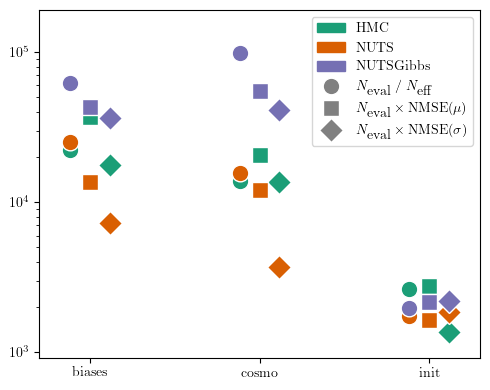

In [38]:
plt.figure(figsize=(5,4))
colors = [plt.get_cmap('Dark2')(i/7) for i in range(len(mc_labels))]
markers = ['o','s','D']
ls = ""
alpha = 1
# ms = 10
# mec = None
ms = 12
mec = 'w'
from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData



usetex = True
theme_switch(usetex=usetex)
for i_mc, (label, mets) in enumerate(zip(mc_labels, metric1)):
    for i_met in range(3):
        # block_names = ['cosmo','biases','init']
        block_names = ['biases','cosmo','init']
        # block_names_lat = ["$\\textrm{biases}$",'$\\textrm{cosmo}$','$\\textrm{init}$']
        met = [mets[k][i_met] for k in block_names]
        if i_met == 0:
            ls = ""
        else:
            ls = ""
        xshifts = 5*np.array([-1,0,1])
        # xshifts = *np.array([0,0,0])
        plt.semilogy(block_names, met, color=colors[i_mc], marker=markers[i_met], 
                     linestyle=ls, alpha=alpha, markersize=ms, markeredgecolor=mec, transform=trans+offset(xshifts[i_met]))

plt.xlim(-.3,2.3), plt.ylim((917, 190842))
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
# # handles, labels = plt.gca().get_legend_handles_labels()
handles = []
for i_traj in range(len(mc_labels)):
    # mc_labels_lat = ["$\\textrm{NUTS}$","$\\textrm{HMC}$","$\\textrm{HMCGibbs}$"]
    handles.append(Patch(color=colors[i_traj], label=mc_labels[i_traj]))
if not usetex:
    metric_names = ["$N_{\\text{eval}}\\;/\\;N_{\\text{eff}}$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\mu)$",
                    "$N_{\\text{eval}} \\times \\operatorname{NMSE}(\\sigma)$"]
else:
    metric_names = ["$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\mu)$",
                    "$N_{\\textrm{eval}} \\times \\textrm{NMSE}(\\sigma)$"]
for i_met, name in enumerate(metric_names):
    handles.append(Line2D([], [], color='grey', marker=markers[i_met], linestyle=ls, label=name, alpha=alpha, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
# plt.savefig('benchmark.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show();

### Highest Density Regions

Removed no burn in
# HMC
using 129024 rows, 6 parameters; mean weight 1.0, tot weight 129024.0
Equiv number of single samples (sum w)/max(w): 129024
Effective number of weighted samples (sum w)^2/sum(w^2): 129024


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.30      0.01      0.30      0.29      0.32   4129.43      1.00
        b1      0.97      0.03      0.97      0.92      1.02    820.93      1.00
        b2     -0.03      0.01     -0.03     -0.05     -0.01   1522.16      1.00
       bn2     -0.62      0.35     -0.63     -1.18     -0.04   1772.13      1.00
       bs2      0.01      0.05      0.01     -0.07      0.10   1310.78      1.00
    sigma8      0.81      0.01      0.81      0.79      0.83   1082.82      1.00

Removed no burn in
# NUTS
using 40960 rows, 6 parameters; mean weight 1.0, tot weight 40960.0
Equiv number of single samples (sum w)/max(w): 40960
Effective number of weighted samples (sum w)^2/sum(w^2): 40960


     

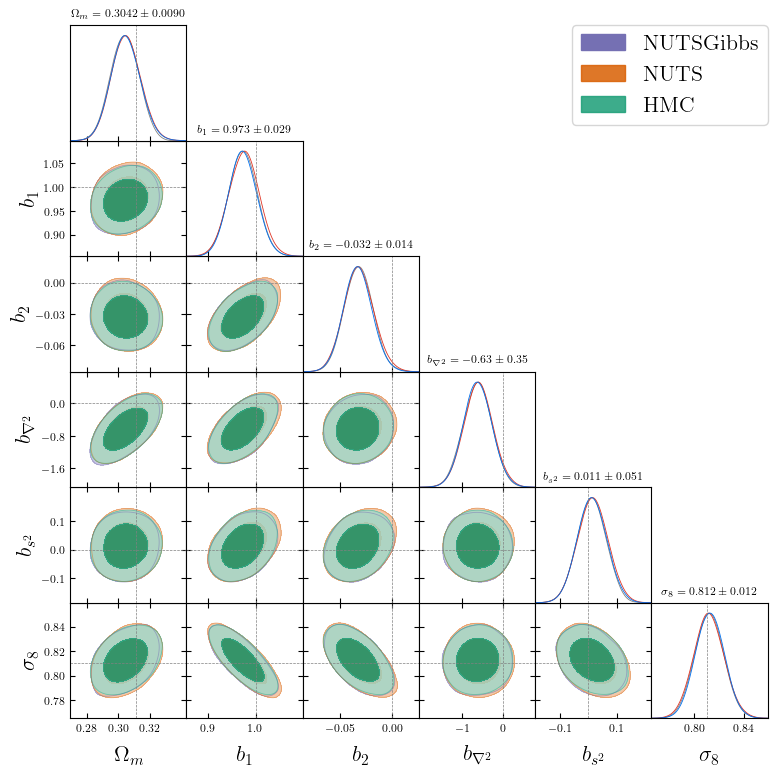

In [63]:
%matplotlib inline
from montecosmo.utils import get_gdsamples, get_gdprior

conc_samples = [tree_map(lambda x: jnp.concatenate(x, axis=0), separate(s, ['num_steps','init_mesh'])[0]) for s in samples]
gdsamples = get_gdsamples(conc_samples, label=mc_labels, verbose=True, **config)
# for i_gds, gds in enumerate(gdsamples): 
#     gdsamples[i_gds] = gds.copy(label=mc_labels[i_gds]+", 1$\\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})
# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))

theme_switch(usetex=True)
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r'
g.settings.fontsize = 100
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 12
g.triangle_plot(roots=gdsamples[::-1], 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                colors=[plt.get_cmap('Dark2')(i/7) for i in range(3)][::-1],
                legend_loc='upper right', 
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
plt.savefig('triangle_bench.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


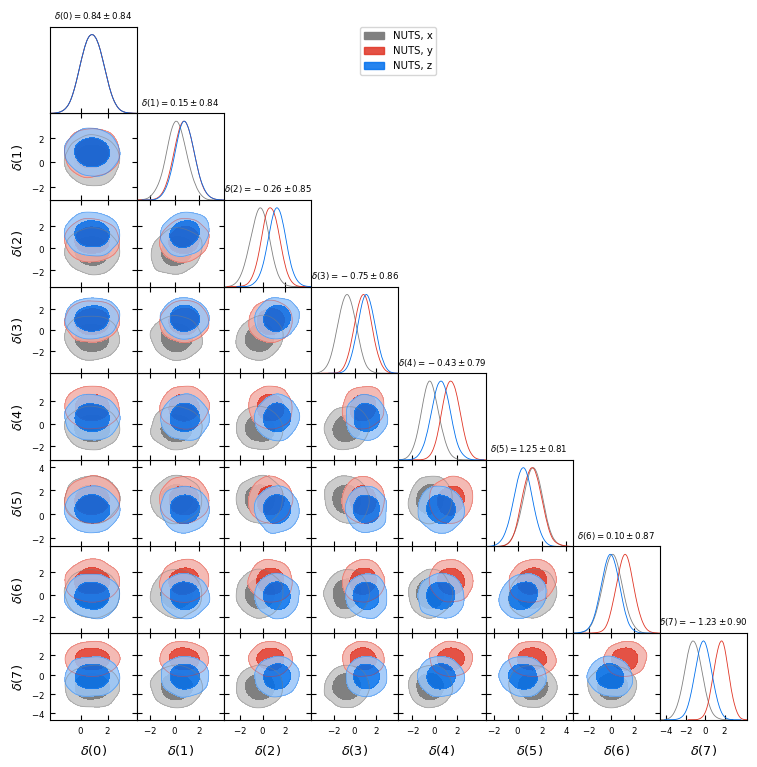

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [11]:
from montecosmo.models import get_pk_fn
pk_fn = get_pk_fn(**config)
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(jnp.concatenate(samples_['init_mesh']))
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:10: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_358767/1372574125.py:8: SyntaxWarning: invalid escape sequence '\%'
  plotfill_fn(pk_1600, pk_8400, alpha=0.15, color=color, label='68\%')
/tmp/ipykernel_358767/1372574125.py:9: SyntaxWarning: invalid escape sequence '\%'
  plotfill_fn(pk_0250, pk_9750, alpha=0.10, color=color, label='95\%')
/tmp/ipykernel_358767/1372574125.py:10: SyntaxWarning: invalid escape sequence '\%'
  plotfill_fn(pk_0015, pk_9985, alpha=0.05, color=color, label='99.7\%')
/tmp/ipykernel_358767/1372574125.py:11: SyntaxWarning: invalid escape sequence '\,'
  plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k\, 

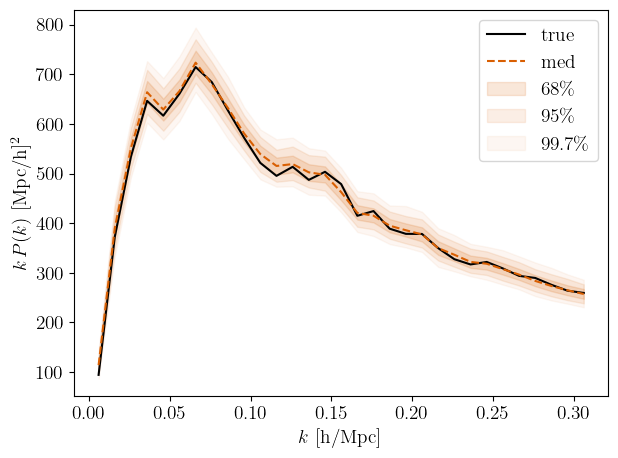

In [39]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

theme_switch(usetex=True, font_size=14)
plot_fn(pk_fiduc, 'k', label='true')
color = plt.get_cmap("Dark2")(1/7)
plot_fn(pk_5000, '--', color=color, label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color=color, label='68\%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color=color, label='95\%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color=color, label='99.7\%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k\, P(k)$ [Mpc/h]$^2$")
plt.legend()
plt.tight_layout()
plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(load_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


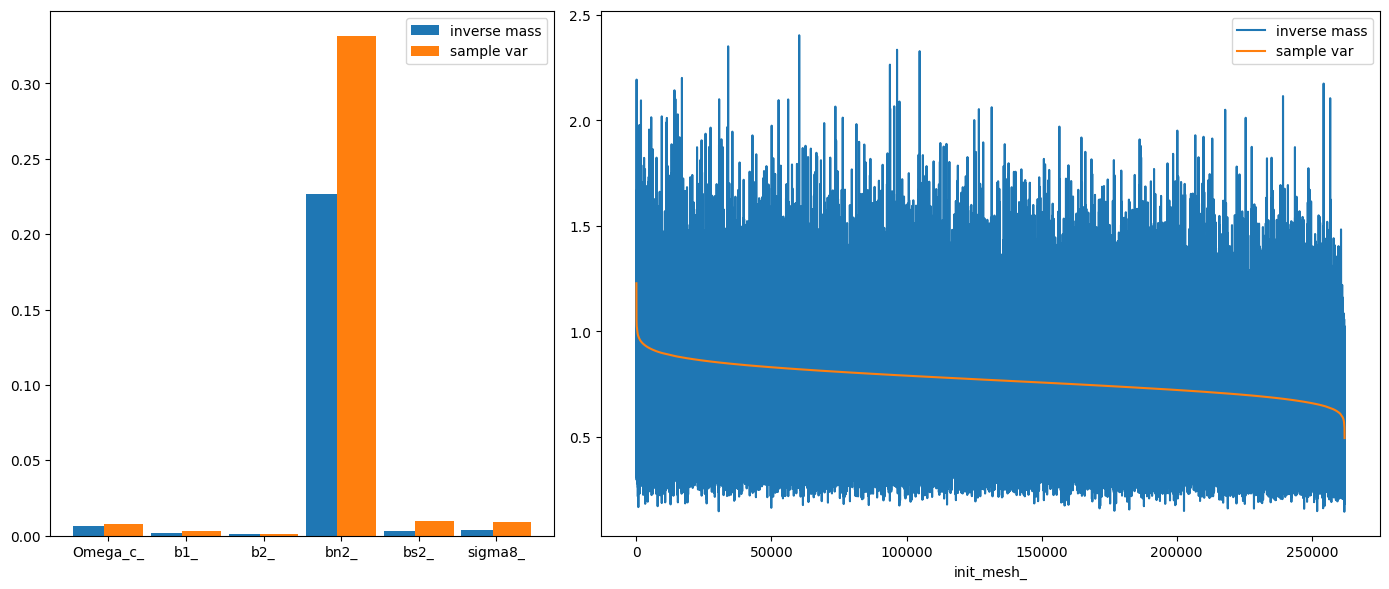

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
# plt.savefig(load_path+"_invMvar.svg");

### Initial field inspection 

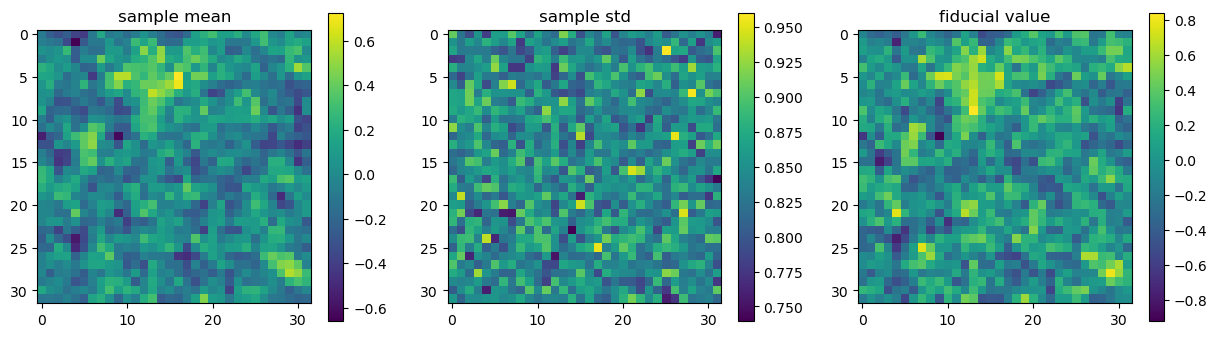

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiduc_params['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();